# Real Estate Price Prediction

1. Загрузка данных
3. Обработка выбросов
4. Обработка пропусков
5. Построение новых признаков
6. Отбор признаков
7. Разбиение на train и test
8. Построение модели
9. Прогнозирование на тестовом датасете

## Подключение библиотек и скриптов

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd

import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 3. Используемая модель (метрика была лучше всех)
from catboost import CatBoostRegressor

# 4. Метрики качества
from sklearn.metrics import r2_score as r2

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

### Функция вывода метрики R2 и визуализация расчетной и фактической стоимости

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Функция уменьшения объема памяти, занимаемого датасетом

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Пути к файлам

In [4]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
SUBMISSION_DATASET_PATH = 'data/sample_submission.csv'

## Загрузка данных

#### Описание датасета:

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 55.0%


In [6]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [7]:
train_df.dtypes

Id                 int16
DistrictId         int16
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
HouseFloor       float32
HouseYear          int32
Ecology_1        float32
Ecology_2         object
Ecology_3         object
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1     float32
Helthcare_2         int8
Shops_1             int8
Shops_2           object
Price            float32
dtype: object

In [8]:
for i in train_df:
    print(i, train_df[i].drop_duplicates().shape[0])

Id 10000
DistrictId 205
Rooms 9
Square 9995
LifeSquare 7887
KitchenSquare 58
Floor 33
HouseFloor 44
HouseYear 97
Ecology_1 129
Ecology_2 2
Ecology_3 2
Social_1 51
Social_2 142
Social_3 30
Healthcare_1 80
Helthcare_2 7
Shops_1 16
Shops_2 2
Price 9996


#### У признаки, вариативность которых < 20, был изменен тип данных, так как это, скорее всего, категориальные признаки.

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Social_3'] = train_df['Social_3'].astype(str)
train_df['Helthcare_2'] = train_df['Helthcare_2'].astype(str)
train_df['Shops_1'] = train_df['Shops_1'].astype(str)

## EDA

### Распределение целевой переменной

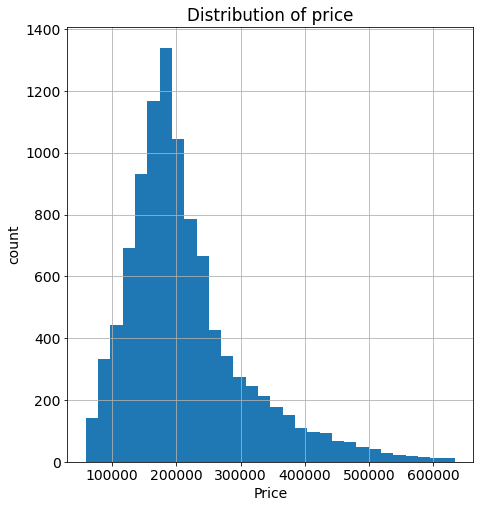

In [10]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of price')
plt.show()

In [11]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Healthcare_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000
mean,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,1142.904419,214138.859375
std,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,1021.517273,92872.289062
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,350.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,900.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,1548.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,4849.000000,633233.437500


## Обработка выбросов

### Rooms

In [12]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [13]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

In [14]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

### Square

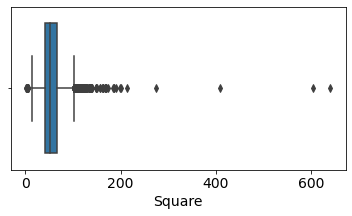

In [15]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

<AxesSubplot:>

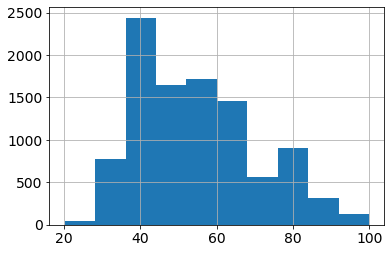

In [16]:
train_df.loc[(train_df['Square'] > 100) | (train_df['Square'] < 20), 'Square'] = train_df['Square'].median()
train_df['Square'].hist()

### LifeSquare

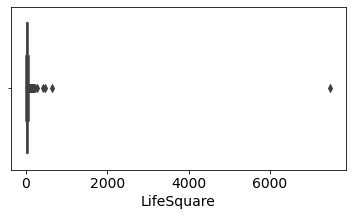

In [17]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

<AxesSubplot:>

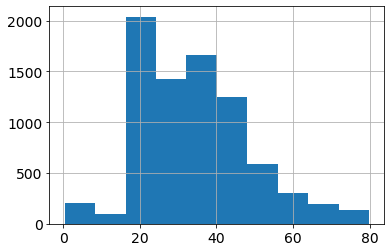

In [18]:
train_df.loc[(train_df['LifeSquare'] > 80), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df['LifeSquare'].hist()

### KitchenSquare

In [19]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [20]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

### HouseFloor

In [21]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [22]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [23]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [24]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

### HouseYear

In [25]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [26]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

## Обработка пропусков

In [27]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

### LifeSquare

In [28]:
train_df['LifeSquare_nan'] = 0

train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

train_df['LifeSquare_nan'].value_counts()

0    7887
1    2113
Name: LifeSquare_nan, dtype: int64

In [29]:
median_ls = train_df['LifeSquare'].median()
train_df['LifeSquare'] = train_df['LifeSquare'].fillna(median_ls)
train_df['LifeSquare'].isna().sum()

0

### Healthcare_1

In [30]:
train_df['Healthcare_1_nan'] = 0

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

train_df['Healthcare_1_nan'].value_counts()

0    5202
1    4798
Name: Healthcare_1_nan, dtype: int64

In [31]:
median_ls = train_df['Healthcare_1'].median()
train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(median_ls)
train_df['Healthcare_1'].isna().sum()

0

### Функция подготовки исходных данных

In [32]:
class DataPreprocessing:

    def __init__(self):
        self.medians = None
        
# Статистика
    def fit(self, df):     
        # Расчет медиан
        self.medians = df.median()
        self.kitchen_square_quantile = df['KitchenSquare'].quantile(.975)
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
    
# Трансформация данных
    def transform(self, df):
        df = reduce_mem_usage(df)
        
        df['Id'] = df['Id'].astype(str)
        df['Social_3'] = df['Social_3'].astype(str)
        df['Helthcare_2'] = df['Helthcare_2'].astype(str)
        df['Shops_1'] = df['Shops_1'].astype(str)
        
        # Выбросы
        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        df.loc[(df['Square'] > 100) | (df['Square'] < 20), 'Square'] = self.medians['Square']

        # LifeSquare
        df.loc[(df['LifeSquare'] > 80), 'LifeSquare'] = self.medians['LifeSquare']
        
        # KitchenSquare
        condition = (df['KitchenSquare'].isna()) \
                    | (df['KitchenSquare'] > self.kitchen_square_quantile)
        
        df.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1

        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
        .apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
                
        # HouseYear
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # Пропуски
        # LifeSquare
        df['LifeSquare_nan'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        
        df['LifeSquare'].fillna(self.medians['LifeSquare'], inplace=True)
        
        # Healthcare_1
        df['Healthcare_1_nan'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        df['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        
        return df

## Построение новых признаков

In [33]:
train_df.drop(columns=['Id'], inplace=True)

### Доля жилой площади относительно общей площади

In [34]:
train_df['LifeSquare_share'] = train_df['LifeSquare'] / train_df['Square'] * 100
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,LifeSquare_share
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,B,...,900.0,0,0,B,305018.875000,0,0,1,1,62.424671
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,...,1183.0,1,0,B,177734.546875,0,0,0,0,58.166592
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,...,240.0,3,1,B,282078.718750,0,0,0,0,60.850937
3,1,1.0,40.409908,32.781261,3.0,10,22.0,1977,0.007122,B,...,900.0,0,1,B,168106.000000,0,0,1,1,81.121841
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,900.0,0,6,B,343995.093750,0,0,0,1,59.986740


### Ecology_2, Ecology_3, Shops_2 (Бинарные переменные)

In [35]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

### DistrictSize, IsDistrictLarge

In [36]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [37]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

### Среднее значение признака Healthcare_1 по району

In [38]:
Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False).agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})

In [39]:
train_df = train_df.merge(Healthcare_1_by_DistrictId, on="DistrictId", how='left')
train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)

In [40]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,LifeSquare_share,DistrictSize,IsDistrictLarge,AverageHealthcare_1
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,1,...,1,305018.875000,0,0,1,1,62.424671,851,1,900.000000
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,1,177734.546875,0,0,0,0,58.166592,78,0,1194.769287
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,1,282078.718750,0,0,0,0,60.850937,652,1,841.319031
3,1,1.0,40.409908,32.781261,3.0,10,22.0,1977,0.007122,1,...,1,168106.000000,0,0,1,1,81.121841,652,1,841.319031
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,1,343995.093750,0,0,0,1,59.986740,89,0,900.000000


### Функция генерации новых данных

In [41]:
class FeatureGenetator():
    
    def __init__(self):
       
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.district_size = None
        self.Healthcare_1_by_DistrictId = None
        
    def fit(self, df, y=None):
        
        df = df.copy()
        self.medians = df.median()
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = df['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        self.medians['AverageHealthcare_1'] = self.Healthcare_1_by_DistrictId['AverageHealthcare_1'].median()
                
    def transform(self, df):
        df = reduce_mem_usage(df)
        
        # Доля жилой площади относительно общей площади
        df['LifeSquare_share'] = df['LifeSquare'] / df['Square'] * 100
        
        # Бинарные переменные
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)  
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        df = df.merge(self.district_size, on='DistrictId', how='left')
        
        df['new_district'] = 0
        df.loc[df['DistrictSize'].isna(), 'new_district'] = 1
        
        df['DistrictSize'].fillna(5, inplace=True)
        
        df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
        
        # Среднее значение Healthcare_1 по району
        df = df.merge(self.Healthcare_1_by_DistrictId, on='DistrictId', how='left')
        df['AverageHealthcare_1'].fillna(self.medians['AverageHealthcare_1'], inplace=True)
        
       
        return df

## Отбор новых признаков

In [42]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'LifeSquare_share',
 'DistrictSize',
 'IsDistrictLarge',
 'AverageHealthcare_1']

In [43]:
model_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare_share', 'Rooms_outlier', 'DistrictSize', 
                     'new_district', 'IsDistrictLarge', 'LifeSquare_nan', 'Healthcare_1_nan']


target_name = 'Price'

## Разбиение на train и test

In [44]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [46]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

Memory usage of dataframe is 1.02 MB
Memory usage after optimization is: 0.49 MB
Decreased by 52.5%
Memory usage of dataframe is 0.50 MB
Memory usage after optimization is: 0.23 MB
Decreased by 53.8%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.31 MB
Decreased by 56.6%


((6700, 23), (3300, 23), (5000, 23))

In [47]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

Memory usage of dataframe is 1.15 MB
Memory usage after optimization is: 0.92 MB
Decreased by 20.5%
Memory usage of dataframe is 0.56 MB
Memory usage after optimization is: 0.45 MB
Decreased by 19.5%
Memory usage of dataframe is 0.62 MB
Memory usage after optimization is: 0.46 MB
Decreased by 26.7%


((6700, 28), (3300, 28), (5000, 28))

In [48]:
X_train = X_train[model_features]
X_valid = X_valid[model_features]
test_df = test_df[model_features]

## Построение модели

### Обучение

In [49]:
cat = CatBoostRegressor(iterations=1000, max_depth=8, eval_metric='R2', random_state=42)
cat.fit(X_train,y_train, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.055297
0:	learn: 0.0577887	total: 64.4ms	remaining: 1m 4s
1:	learn: 0.1085365	total: 74.9ms	remaining: 37.4s
2:	learn: 0.1553525	total: 86.6ms	remaining: 28.8s
3:	learn: 0.2012135	total: 98.4ms	remaining: 24.5s
4:	learn: 0.2418456	total: 112ms	remaining: 22.2s
5:	learn: 0.2782688	total: 121ms	remaining: 20.1s
6:	learn: 0.3086848	total: 134ms	remaining: 19s
7:	learn: 0.3393645	total: 145ms	remaining: 18s
8:	learn: 0.3651855	total: 156ms	remaining: 17.2s
9:	learn: 0.3889545	total: 164ms	remaining: 16.3s
10:	learn: 0.4148258	total: 173ms	remaining: 15.5s
11:	learn: 0.4356826	total: 180ms	remaining: 14.8s
12:	learn: 0.4554653	total: 187ms	remaining: 14.2s
13:	learn: 0.4746358	total: 197ms	remaining: 13.9s
14:	learn: 0.4916953	total: 204ms	remaining: 13.4s
15:	learn: 0.5060855	total: 212ms	remaining: 13.1s
16:	learn: 0.5210528	total: 221ms	remaining: 12.8s
17:	learn: 0.5338245	total: 229ms	remaining: 12.5s
18:	learn: 0.5469216	total: 238ms	remaining: 12.3s
19:	learn: 

180:	learn: 0.8169115	total: 1.71s	remaining: 7.73s
181:	learn: 0.8173785	total: 1.71s	remaining: 7.71s
182:	learn: 0.8176661	total: 1.72s	remaining: 7.69s
183:	learn: 0.8183769	total: 1.73s	remaining: 7.66s
184:	learn: 0.8189952	total: 1.73s	remaining: 7.64s
185:	learn: 0.8196676	total: 1.74s	remaining: 7.62s
186:	learn: 0.8202474	total: 1.75s	remaining: 7.6s
187:	learn: 0.8206073	total: 1.76s	remaining: 7.59s
188:	learn: 0.8213893	total: 1.76s	remaining: 7.57s
189:	learn: 0.8219686	total: 1.77s	remaining: 7.55s
190:	learn: 0.8225746	total: 1.78s	remaining: 7.53s
191:	learn: 0.8230802	total: 1.78s	remaining: 7.5s
192:	learn: 0.8233669	total: 1.79s	remaining: 7.49s
193:	learn: 0.8237964	total: 1.8s	remaining: 7.48s
194:	learn: 0.8242577	total: 1.81s	remaining: 7.47s
195:	learn: 0.8245470	total: 1.82s	remaining: 7.45s
196:	learn: 0.8247982	total: 1.82s	remaining: 7.43s
197:	learn: 0.8255789	total: 1.83s	remaining: 7.41s
198:	learn: 0.8259972	total: 1.83s	remaining: 7.39s
199:	learn: 0.8

349:	learn: 0.8728180	total: 3s	remaining: 5.57s
350:	learn: 0.8731365	total: 3.01s	remaining: 5.56s
351:	learn: 0.8733169	total: 3.01s	remaining: 5.55s
352:	learn: 0.8734358	total: 3.02s	remaining: 5.54s
353:	learn: 0.8736110	total: 3.03s	remaining: 5.53s
354:	learn: 0.8737734	total: 3.04s	remaining: 5.52s
355:	learn: 0.8739192	total: 3.05s	remaining: 5.52s
356:	learn: 0.8740999	total: 3.06s	remaining: 5.51s
357:	learn: 0.8742323	total: 3.07s	remaining: 5.5s
358:	learn: 0.8742883	total: 3.07s	remaining: 5.49s
359:	learn: 0.8743508	total: 3.08s	remaining: 5.48s
360:	learn: 0.8745390	total: 3.09s	remaining: 5.47s
361:	learn: 0.8747105	total: 3.09s	remaining: 5.45s
362:	learn: 0.8748413	total: 3.1s	remaining: 5.44s
363:	learn: 0.8750056	total: 3.11s	remaining: 5.43s
364:	learn: 0.8751428	total: 3.11s	remaining: 5.42s
365:	learn: 0.8753872	total: 3.12s	remaining: 5.41s
366:	learn: 0.8756840	total: 3.13s	remaining: 5.4s
367:	learn: 0.8759802	total: 3.14s	remaining: 5.39s
368:	learn: 0.8762

509:	learn: 0.9006933	total: 4.31s	remaining: 4.14s
510:	learn: 0.9008071	total: 4.32s	remaining: 4.13s
511:	learn: 0.9009450	total: 4.33s	remaining: 4.13s
512:	learn: 0.9010349	total: 4.33s	remaining: 4.12s
513:	learn: 0.9011336	total: 4.34s	remaining: 4.11s
514:	learn: 0.9012894	total: 4.35s	remaining: 4.09s
515:	learn: 0.9013786	total: 4.36s	remaining: 4.09s
516:	learn: 0.9014453	total: 4.36s	remaining: 4.08s
517:	learn: 0.9015865	total: 4.37s	remaining: 4.07s
518:	learn: 0.9017410	total: 4.38s	remaining: 4.05s
519:	learn: 0.9018367	total: 4.38s	remaining: 4.04s
520:	learn: 0.9020095	total: 4.39s	remaining: 4.03s
521:	learn: 0.9021488	total: 4.4s	remaining: 4.03s
522:	learn: 0.9023294	total: 4.4s	remaining: 4.01s
523:	learn: 0.9026097	total: 4.41s	remaining: 4.01s
524:	learn: 0.9027364	total: 4.42s	remaining: 4s
525:	learn: 0.9028731	total: 4.43s	remaining: 3.99s
526:	learn: 0.9029924	total: 4.43s	remaining: 3.98s
527:	learn: 0.9031559	total: 4.44s	remaining: 3.97s
528:	learn: 0.903

678:	learn: 0.9208007	total: 5.75s	remaining: 2.72s
679:	learn: 0.9209416	total: 5.76s	remaining: 2.71s
680:	learn: 0.9210401	total: 5.76s	remaining: 2.7s
681:	learn: 0.9211608	total: 5.78s	remaining: 2.69s
682:	learn: 0.9212527	total: 5.79s	remaining: 2.69s
683:	learn: 0.9212773	total: 5.79s	remaining: 2.68s
684:	learn: 0.9214051	total: 5.8s	remaining: 2.67s
685:	learn: 0.9215094	total: 5.81s	remaining: 2.66s
686:	learn: 0.9215905	total: 5.83s	remaining: 2.66s
687:	learn: 0.9217223	total: 5.84s	remaining: 2.65s
688:	learn: 0.9217970	total: 5.85s	remaining: 2.64s
689:	learn: 0.9218482	total: 5.86s	remaining: 2.63s
690:	learn: 0.9218970	total: 5.86s	remaining: 2.62s
691:	learn: 0.9220201	total: 5.87s	remaining: 2.61s
692:	learn: 0.9221333	total: 5.88s	remaining: 2.6s
693:	learn: 0.9223568	total: 5.88s	remaining: 2.59s
694:	learn: 0.9224462	total: 5.89s	remaining: 2.58s
695:	learn: 0.9226105	total: 5.89s	remaining: 2.58s
696:	learn: 0.9227900	total: 5.9s	remaining: 2.56s
697:	learn: 0.92

842:	learn: 0.9341645	total: 7.09s	remaining: 1.32s
843:	learn: 0.9342196	total: 7.1s	remaining: 1.31s
844:	learn: 0.9342642	total: 7.11s	remaining: 1.3s
845:	learn: 0.9343390	total: 7.11s	remaining: 1.29s
846:	learn: 0.9344115	total: 7.12s	remaining: 1.29s
847:	learn: 0.9344155	total: 7.13s	remaining: 1.28s
848:	learn: 0.9344761	total: 7.14s	remaining: 1.27s
849:	learn: 0.9345476	total: 7.14s	remaining: 1.26s
850:	learn: 0.9346701	total: 7.15s	remaining: 1.25s
851:	learn: 0.9347356	total: 7.16s	remaining: 1.24s
852:	learn: 0.9348135	total: 7.17s	remaining: 1.23s
853:	learn: 0.9348732	total: 7.17s	remaining: 1.23s
854:	learn: 0.9349626	total: 7.18s	remaining: 1.22s
855:	learn: 0.9351038	total: 7.19s	remaining: 1.21s
856:	learn: 0.9351609	total: 7.2s	remaining: 1.2s
857:	learn: 0.9351956	total: 7.2s	remaining: 1.19s
858:	learn: 0.9352529	total: 7.21s	remaining: 1.18s
859:	learn: 0.9352729	total: 7.21s	remaining: 1.17s
860:	learn: 0.9353282	total: 7.23s	remaining: 1.17s
861:	learn: 0.935

### Оценка модели

Train R2:	0.944
Test R2:	0.762


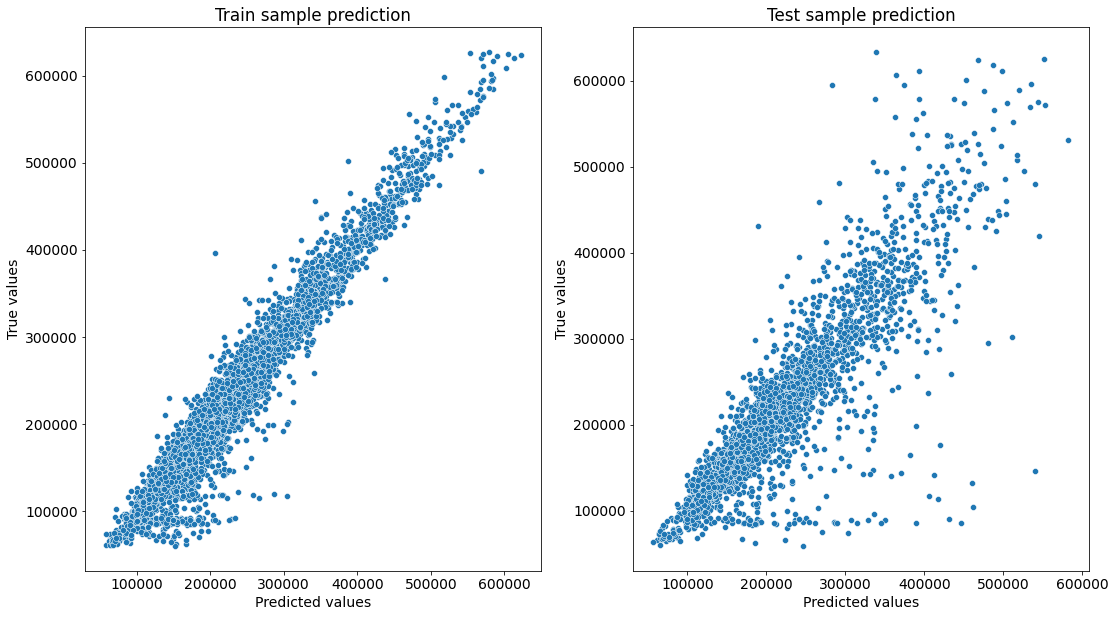

In [50]:
y_train_preds = cat.predict(X_train)
y_valid_preds = cat.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### Кросс-валидация

In [51]:
cv_score = cross_val_score(cat, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

Learning rate set to 0.053381
0:	learn: 0.0536965	total: 10.2ms	remaining: 10.1s
1:	learn: 0.1028535	total: 16.6ms	remaining: 8.27s
2:	learn: 0.1490913	total: 23.6ms	remaining: 7.83s
3:	learn: 0.1921044	total: 31.2ms	remaining: 7.76s
4:	learn: 0.2312107	total: 37.3ms	remaining: 7.43s
5:	learn: 0.2672070	total: 45.9ms	remaining: 7.6s
6:	learn: 0.2981876	total: 52.3ms	remaining: 7.42s
7:	learn: 0.3286062	total: 61.1ms	remaining: 7.57s
8:	learn: 0.3556890	total: 70.9ms	remaining: 7.81s
9:	learn: 0.3796539	total: 79ms	remaining: 7.82s
10:	learn: 0.4037589	total: 85.8ms	remaining: 7.72s
11:	learn: 0.4244869	total: 93.5ms	remaining: 7.7s
12:	learn: 0.4459433	total: 99.3ms	remaining: 7.54s
13:	learn: 0.4638201	total: 107ms	remaining: 7.56s
14:	learn: 0.4815566	total: 113ms	remaining: 7.45s
15:	learn: 0.4966569	total: 119ms	remaining: 7.31s
16:	learn: 0.5101994	total: 130ms	remaining: 7.52s
17:	learn: 0.5221606	total: 139ms	remaining: 7.61s
18:	learn: 0.5351331	total: 147ms	remaining: 7.59s
19

181:	learn: 0.8247265	total: 1.46s	remaining: 6.56s
182:	learn: 0.8253727	total: 1.47s	remaining: 6.55s
183:	learn: 0.8259017	total: 1.48s	remaining: 6.54s
184:	learn: 0.8262723	total: 1.48s	remaining: 6.53s
185:	learn: 0.8266478	total: 1.49s	remaining: 6.53s
186:	learn: 0.8270462	total: 1.5s	remaining: 6.51s
187:	learn: 0.8274151	total: 1.51s	remaining: 6.51s
188:	learn: 0.8278458	total: 1.51s	remaining: 6.49s
189:	learn: 0.8282480	total: 1.52s	remaining: 6.5s
190:	learn: 0.8285890	total: 1.53s	remaining: 6.5s
191:	learn: 0.8289072	total: 1.54s	remaining: 6.48s
192:	learn: 0.8291506	total: 1.55s	remaining: 6.47s
193:	learn: 0.8298148	total: 1.55s	remaining: 6.46s
194:	learn: 0.8305521	total: 1.56s	remaining: 6.45s
195:	learn: 0.8311528	total: 1.57s	remaining: 6.44s
196:	learn: 0.8315494	total: 1.57s	remaining: 6.42s
197:	learn: 0.8321074	total: 1.58s	remaining: 6.41s
198:	learn: 0.8327564	total: 1.59s	remaining: 6.4s
199:	learn: 0.8332076	total: 1.6s	remaining: 6.4s
200:	learn: 0.8335

358:	learn: 0.8841455	total: 2.79s	remaining: 4.99s
359:	learn: 0.8843003	total: 2.8s	remaining: 4.98s
360:	learn: 0.8846019	total: 2.81s	remaining: 4.97s
361:	learn: 0.8849446	total: 2.82s	remaining: 4.96s
362:	learn: 0.8851558	total: 2.82s	remaining: 4.95s
363:	learn: 0.8853464	total: 2.83s	remaining: 4.94s
364:	learn: 0.8856599	total: 2.84s	remaining: 4.93s
365:	learn: 0.8857929	total: 2.84s	remaining: 4.92s
366:	learn: 0.8860422	total: 2.85s	remaining: 4.91s
367:	learn: 0.8862515	total: 2.85s	remaining: 4.9s
368:	learn: 0.8864238	total: 2.86s	remaining: 4.89s
369:	learn: 0.8865695	total: 2.87s	remaining: 4.88s
370:	learn: 0.8868054	total: 2.87s	remaining: 4.87s
371:	learn: 0.8870055	total: 2.88s	remaining: 4.86s
372:	learn: 0.8872818	total: 2.89s	remaining: 4.85s
373:	learn: 0.8874023	total: 2.89s	remaining: 4.84s
374:	learn: 0.8875758	total: 2.9s	remaining: 4.83s
375:	learn: 0.8877109	total: 2.91s	remaining: 4.82s
376:	learn: 0.8879543	total: 2.91s	remaining: 4.81s
377:	learn: 0.8

537:	learn: 0.9125024	total: 4.11s	remaining: 3.53s
538:	learn: 0.9126042	total: 4.12s	remaining: 3.52s
539:	learn: 0.9126727	total: 4.12s	remaining: 3.51s
540:	learn: 0.9128126	total: 4.13s	remaining: 3.5s
541:	learn: 0.9129883	total: 4.14s	remaining: 3.5s
542:	learn: 0.9131390	total: 4.15s	remaining: 3.49s
543:	learn: 0.9133135	total: 4.15s	remaining: 3.48s
544:	learn: 0.9133265	total: 4.16s	remaining: 3.47s
545:	learn: 0.9134038	total: 4.17s	remaining: 3.47s
546:	learn: 0.9135315	total: 4.17s	remaining: 3.46s
547:	learn: 0.9136371	total: 4.18s	remaining: 3.45s
548:	learn: 0.9138232	total: 4.19s	remaining: 3.44s
549:	learn: 0.9140636	total: 4.2s	remaining: 3.43s
550:	learn: 0.9140760	total: 4.21s	remaining: 3.43s
551:	learn: 0.9143141	total: 4.21s	remaining: 3.42s
552:	learn: 0.9143847	total: 4.22s	remaining: 3.41s
553:	learn: 0.9144511	total: 4.23s	remaining: 3.4s
554:	learn: 0.9146177	total: 4.24s	remaining: 3.4s
555:	learn: 0.9147879	total: 4.25s	remaining: 3.39s
556:	learn: 0.914

716:	learn: 0.9315141	total: 5.43s	remaining: 2.14s
717:	learn: 0.9315692	total: 5.44s	remaining: 2.14s
718:	learn: 0.9316390	total: 5.45s	remaining: 2.13s
719:	learn: 0.9317707	total: 5.45s	remaining: 2.12s
720:	learn: 0.9318777	total: 5.46s	remaining: 2.11s
721:	learn: 0.9319693	total: 5.47s	remaining: 2.1s
722:	learn: 0.9321254	total: 5.47s	remaining: 2.1s
723:	learn: 0.9321483	total: 5.48s	remaining: 2.09s
724:	learn: 0.9321813	total: 5.48s	remaining: 2.08s
725:	learn: 0.9322173	total: 5.49s	remaining: 2.07s
726:	learn: 0.9323108	total: 5.5s	remaining: 2.06s
727:	learn: 0.9323163	total: 5.5s	remaining: 2.05s
728:	learn: 0.9323935	total: 5.5s	remaining: 2.05s
729:	learn: 0.9324547	total: 5.51s	remaining: 2.04s
730:	learn: 0.9325854	total: 5.52s	remaining: 2.03s
731:	learn: 0.9326752	total: 5.52s	remaining: 2.02s
732:	learn: 0.9327062	total: 5.53s	remaining: 2.01s
733:	learn: 0.9327704	total: 5.54s	remaining: 2.01s
734:	learn: 0.9328018	total: 5.54s	remaining: 2s
735:	learn: 0.932921

877:	learn: 0.9439538	total: 6.53s	remaining: 907ms
878:	learn: 0.9440061	total: 6.54s	remaining: 900ms
879:	learn: 0.9440809	total: 6.54s	remaining: 892ms
880:	learn: 0.9441476	total: 6.55s	remaining: 885ms
881:	learn: 0.9441688	total: 6.56s	remaining: 878ms
882:	learn: 0.9442393	total: 6.57s	remaining: 871ms
883:	learn: 0.9443040	total: 6.58s	remaining: 863ms
884:	learn: 0.9443442	total: 6.59s	remaining: 856ms
885:	learn: 0.9444065	total: 6.6s	remaining: 849ms
886:	learn: 0.9444365	total: 6.6s	remaining: 841ms
887:	learn: 0.9444933	total: 6.61s	remaining: 834ms
888:	learn: 0.9445569	total: 6.62s	remaining: 827ms
889:	learn: 0.9446097	total: 6.63s	remaining: 819ms
890:	learn: 0.9446803	total: 6.64s	remaining: 812ms
891:	learn: 0.9446985	total: 6.64s	remaining: 804ms
892:	learn: 0.9447395	total: 6.65s	remaining: 797ms
893:	learn: 0.9448182	total: 6.66s	remaining: 789ms
894:	learn: 0.9448656	total: 6.66s	remaining: 782ms
895:	learn: 0.9449172	total: 6.67s	remaining: 774ms
896:	learn: 0.

48:	learn: 0.7070640	total: 382ms	remaining: 7.41s
49:	learn: 0.7096143	total: 393ms	remaining: 7.46s
50:	learn: 0.7113470	total: 402ms	remaining: 7.48s
51:	learn: 0.7137247	total: 411ms	remaining: 7.49s
52:	learn: 0.7162143	total: 417ms	remaining: 7.45s
53:	learn: 0.7182320	total: 424ms	remaining: 7.42s
54:	learn: 0.7200892	total: 430ms	remaining: 7.38s
55:	learn: 0.7214759	total: 436ms	remaining: 7.35s
56:	learn: 0.7232261	total: 442ms	remaining: 7.32s
57:	learn: 0.7246525	total: 448ms	remaining: 7.28s
58:	learn: 0.7268001	total: 455ms	remaining: 7.25s
59:	learn: 0.7284204	total: 461ms	remaining: 7.22s
60:	learn: 0.7300398	total: 467ms	remaining: 7.18s
61:	learn: 0.7315866	total: 473ms	remaining: 7.16s
62:	learn: 0.7331245	total: 479ms	remaining: 7.13s
63:	learn: 0.7340995	total: 486ms	remaining: 7.1s
64:	learn: 0.7358506	total: 492ms	remaining: 7.07s
65:	learn: 0.7371743	total: 498ms	remaining: 7.05s
66:	learn: 0.7385234	total: 504ms	remaining: 7.02s
67:	learn: 0.7399212	total: 510m

218:	learn: 0.8364092	total: 1.48s	remaining: 5.29s
219:	learn: 0.8367895	total: 1.49s	remaining: 5.29s
220:	learn: 0.8371790	total: 1.5s	remaining: 5.28s
221:	learn: 0.8378453	total: 1.5s	remaining: 5.27s
222:	learn: 0.8386814	total: 1.51s	remaining: 5.27s
223:	learn: 0.8387431	total: 1.52s	remaining: 5.26s
224:	learn: 0.8391604	total: 1.52s	remaining: 5.25s
225:	learn: 0.8397675	total: 1.53s	remaining: 5.25s
226:	learn: 0.8402411	total: 1.54s	remaining: 5.24s
227:	learn: 0.8402982	total: 1.54s	remaining: 5.23s
228:	learn: 0.8405211	total: 1.55s	remaining: 5.22s
229:	learn: 0.8405756	total: 1.56s	remaining: 5.21s
230:	learn: 0.8413975	total: 1.56s	remaining: 5.21s
231:	learn: 0.8414751	total: 1.57s	remaining: 5.21s
232:	learn: 0.8415345	total: 1.58s	remaining: 5.19s
233:	learn: 0.8420661	total: 1.58s	remaining: 5.19s
234:	learn: 0.8422767	total: 1.59s	remaining: 5.18s
235:	learn: 0.8424308	total: 1.6s	remaining: 5.18s
236:	learn: 0.8428931	total: 1.61s	remaining: 5.17s
237:	learn: 0.8

393:	learn: 0.8844554	total: 2.76s	remaining: 4.25s
394:	learn: 0.8846389	total: 2.77s	remaining: 4.24s
395:	learn: 0.8847980	total: 2.78s	remaining: 4.24s
396:	learn: 0.8849586	total: 2.79s	remaining: 4.24s
397:	learn: 0.8852371	total: 2.8s	remaining: 4.23s
398:	learn: 0.8853206	total: 2.81s	remaining: 4.23s
399:	learn: 0.8853758	total: 2.81s	remaining: 4.22s
400:	learn: 0.8856791	total: 2.82s	remaining: 4.22s
401:	learn: 0.8858555	total: 2.83s	remaining: 4.21s
402:	learn: 0.8860631	total: 2.84s	remaining: 4.2s
403:	learn: 0.8862381	total: 2.84s	remaining: 4.2s
404:	learn: 0.8864201	total: 2.85s	remaining: 4.19s
405:	learn: 0.8867998	total: 2.86s	remaining: 4.19s
406:	learn: 0.8870516	total: 2.87s	remaining: 4.18s
407:	learn: 0.8872952	total: 2.88s	remaining: 4.18s
408:	learn: 0.8874985	total: 2.89s	remaining: 4.17s
409:	learn: 0.8877604	total: 2.9s	remaining: 4.17s
410:	learn: 0.8878630	total: 2.9s	remaining: 4.16s
411:	learn: 0.8881507	total: 2.91s	remaining: 4.16s
412:	learn: 0.888

566:	learn: 0.9122557	total: 4.04s	remaining: 3.09s
567:	learn: 0.9123928	total: 4.05s	remaining: 3.08s
568:	learn: 0.9125551	total: 4.06s	remaining: 3.08s
569:	learn: 0.9127166	total: 4.07s	remaining: 3.07s
570:	learn: 0.9128276	total: 4.07s	remaining: 3.06s
571:	learn: 0.9130153	total: 4.08s	remaining: 3.05s
572:	learn: 0.9130278	total: 4.09s	remaining: 3.05s
573:	learn: 0.9131552	total: 4.1s	remaining: 3.04s
574:	learn: 0.9132728	total: 4.11s	remaining: 3.03s
575:	learn: 0.9134356	total: 4.11s	remaining: 3.03s
576:	learn: 0.9134971	total: 4.12s	remaining: 3.02s
577:	learn: 0.9136303	total: 4.13s	remaining: 3.02s
578:	learn: 0.9138386	total: 4.14s	remaining: 3.01s
579:	learn: 0.9140315	total: 4.14s	remaining: 3s
580:	learn: 0.9141815	total: 4.15s	remaining: 2.99s
581:	learn: 0.9142806	total: 4.16s	remaining: 2.99s
582:	learn: 0.9143931	total: 4.17s	remaining: 2.98s
583:	learn: 0.9144092	total: 4.17s	remaining: 2.97s
584:	learn: 0.9145114	total: 4.18s	remaining: 2.97s
585:	learn: 0.91

725:	learn: 0.9309283	total: 5.32s	remaining: 2.01s
726:	learn: 0.9310566	total: 5.33s	remaining: 2s
727:	learn: 0.9311544	total: 5.34s	remaining: 2s
728:	learn: 0.9312344	total: 5.35s	remaining: 1.99s
729:	learn: 0.9312971	total: 5.35s	remaining: 1.98s
730:	learn: 0.9313934	total: 5.36s	remaining: 1.97s
731:	learn: 0.9315413	total: 5.37s	remaining: 1.97s
732:	learn: 0.9316494	total: 5.38s	remaining: 1.96s
733:	learn: 0.9318207	total: 5.38s	remaining: 1.95s
734:	learn: 0.9318936	total: 5.39s	remaining: 1.94s
735:	learn: 0.9320221	total: 5.4s	remaining: 1.94s
736:	learn: 0.9321030	total: 5.4s	remaining: 1.93s
737:	learn: 0.9322109	total: 5.41s	remaining: 1.92s
738:	learn: 0.9323247	total: 5.42s	remaining: 1.91s
739:	learn: 0.9324264	total: 5.43s	remaining: 1.91s
740:	learn: 0.9324864	total: 5.43s	remaining: 1.9s
741:	learn: 0.9325422	total: 5.44s	remaining: 1.89s
742:	learn: 0.9326518	total: 5.45s	remaining: 1.88s
743:	learn: 0.9327299	total: 5.46s	remaining: 1.88s
744:	learn: 0.9328569

911:	learn: 0.9459729	total: 6.62s	remaining: 639ms
912:	learn: 0.9460469	total: 6.63s	remaining: 632ms
913:	learn: 0.9460809	total: 6.63s	remaining: 624ms
914:	learn: 0.9461573	total: 6.64s	remaining: 617ms
915:	learn: 0.9462204	total: 6.65s	remaining: 610ms
916:	learn: 0.9462909	total: 6.66s	remaining: 603ms
917:	learn: 0.9463477	total: 6.66s	remaining: 595ms
918:	learn: 0.9464146	total: 6.67s	remaining: 588ms
919:	learn: 0.9464924	total: 6.68s	remaining: 581ms
920:	learn: 0.9465604	total: 6.68s	remaining: 573ms
921:	learn: 0.9466269	total: 6.69s	remaining: 566ms
922:	learn: 0.9466678	total: 6.69s	remaining: 559ms
923:	learn: 0.9467022	total: 6.7s	remaining: 551ms
924:	learn: 0.9467403	total: 6.71s	remaining: 544ms
925:	learn: 0.9468194	total: 6.71s	remaining: 537ms
926:	learn: 0.9468796	total: 6.72s	remaining: 529ms
927:	learn: 0.9470119	total: 6.73s	remaining: 522ms
928:	learn: 0.9470613	total: 6.73s	remaining: 515ms
929:	learn: 0.9471000	total: 6.74s	remaining: 507ms
930:	learn: 0

79:	learn: 0.7520465	total: 534ms	remaining: 6.14s
80:	learn: 0.7532453	total: 542ms	remaining: 6.15s
81:	learn: 0.7539530	total: 549ms	remaining: 6.14s
82:	learn: 0.7551987	total: 555ms	remaining: 6.13s
83:	learn: 0.7565392	total: 561ms	remaining: 6.12s
84:	learn: 0.7577360	total: 568ms	remaining: 6.12s
85:	learn: 0.7587508	total: 575ms	remaining: 6.11s
86:	learn: 0.7595310	total: 580ms	remaining: 6.09s
87:	learn: 0.7603321	total: 588ms	remaining: 6.09s
88:	learn: 0.7615199	total: 594ms	remaining: 6.08s
89:	learn: 0.7625753	total: 600ms	remaining: 6.07s
90:	learn: 0.7632936	total: 606ms	remaining: 6.05s
91:	learn: 0.7644572	total: 612ms	remaining: 6.04s
92:	learn: 0.7651850	total: 618ms	remaining: 6.03s
93:	learn: 0.7660424	total: 624ms	remaining: 6.01s
94:	learn: 0.7672202	total: 631ms	remaining: 6.01s
95:	learn: 0.7681437	total: 638ms	remaining: 6s
96:	learn: 0.7692667	total: 643ms	remaining: 5.99s
97:	learn: 0.7698049	total: 650ms	remaining: 5.99s
98:	learn: 0.7707553	total: 657ms	

259:	learn: 0.8591529	total: 1.83s	remaining: 5.2s
260:	learn: 0.8595088	total: 1.84s	remaining: 5.2s
261:	learn: 0.8596704	total: 1.84s	remaining: 5.19s
262:	learn: 0.8597655	total: 1.85s	remaining: 5.18s
263:	learn: 0.8601079	total: 1.86s	remaining: 5.17s
264:	learn: 0.8604905	total: 1.86s	remaining: 5.17s
265:	learn: 0.8605831	total: 1.87s	remaining: 5.16s
266:	learn: 0.8608563	total: 1.88s	remaining: 5.15s
267:	learn: 0.8611967	total: 1.88s	remaining: 5.14s
268:	learn: 0.8614975	total: 1.89s	remaining: 5.13s
269:	learn: 0.8619646	total: 1.89s	remaining: 5.12s
270:	learn: 0.8622252	total: 1.9s	remaining: 5.11s
271:	learn: 0.8625016	total: 1.91s	remaining: 5.1s
272:	learn: 0.8628708	total: 1.91s	remaining: 5.1s
273:	learn: 0.8633069	total: 1.92s	remaining: 5.09s
274:	learn: 0.8637226	total: 1.93s	remaining: 5.08s
275:	learn: 0.8639603	total: 1.93s	remaining: 5.07s
276:	learn: 0.8644274	total: 1.94s	remaining: 5.06s
277:	learn: 0.8646621	total: 1.95s	remaining: 5.05s
278:	learn: 0.865

418:	learn: 0.8964614	total: 2.93s	remaining: 4.06s
419:	learn: 0.8965952	total: 2.93s	remaining: 4.05s
420:	learn: 0.8967739	total: 2.94s	remaining: 4.04s
421:	learn: 0.8968333	total: 2.95s	remaining: 4.04s
422:	learn: 0.8969730	total: 2.95s	remaining: 4.03s
423:	learn: 0.8971297	total: 2.96s	remaining: 4.02s
424:	learn: 0.8972301	total: 2.97s	remaining: 4.01s
425:	learn: 0.8973726	total: 2.97s	remaining: 4.01s
426:	learn: 0.8975997	total: 2.98s	remaining: 4s
427:	learn: 0.8977162	total: 2.99s	remaining: 3.99s
428:	learn: 0.8978046	total: 2.99s	remaining: 3.98s
429:	learn: 0.8978824	total: 3s	remaining: 3.97s
430:	learn: 0.8979878	total: 3s	remaining: 3.97s
431:	learn: 0.8980942	total: 3.01s	remaining: 3.96s
432:	learn: 0.8982282	total: 3.02s	remaining: 3.95s
433:	learn: 0.8984918	total: 3.02s	remaining: 3.94s
434:	learn: 0.8987034	total: 3.03s	remaining: 3.94s
435:	learn: 0.8988030	total: 3.04s	remaining: 3.93s
436:	learn: 0.8989056	total: 3.04s	remaining: 3.92s
437:	learn: 0.8989749

579:	learn: 0.9192535	total: 4.04s	remaining: 2.93s
580:	learn: 0.9193751	total: 4.05s	remaining: 2.92s
581:	learn: 0.9194471	total: 4.06s	remaining: 2.92s
582:	learn: 0.9196309	total: 4.07s	remaining: 2.91s
583:	learn: 0.9197159	total: 4.07s	remaining: 2.9s
584:	learn: 0.9198200	total: 4.08s	remaining: 2.89s
585:	learn: 0.9199455	total: 4.08s	remaining: 2.89s
586:	learn: 0.9200915	total: 4.09s	remaining: 2.88s
587:	learn: 0.9202421	total: 4.1s	remaining: 2.87s
588:	learn: 0.9203865	total: 4.11s	remaining: 2.86s
589:	learn: 0.9204397	total: 4.11s	remaining: 2.86s
590:	learn: 0.9205375	total: 4.12s	remaining: 2.85s
591:	learn: 0.9206607	total: 4.12s	remaining: 2.84s
592:	learn: 0.9207720	total: 4.13s	remaining: 2.83s
593:	learn: 0.9208464	total: 4.14s	remaining: 2.83s
594:	learn: 0.9209516	total: 4.14s	remaining: 2.82s
595:	learn: 0.9210869	total: 4.15s	remaining: 2.81s
596:	learn: 0.9211535	total: 4.16s	remaining: 2.81s
597:	learn: 0.9213045	total: 4.16s	remaining: 2.8s
598:	learn: 0.9

749:	learn: 0.9356519	total: 5.3s	remaining: 1.77s
750:	learn: 0.9357284	total: 5.32s	remaining: 1.76s
751:	learn: 0.9357854	total: 5.32s	remaining: 1.75s
752:	learn: 0.9358440	total: 5.33s	remaining: 1.75s
753:	learn: 0.9359258	total: 5.33s	remaining: 1.74s
754:	learn: 0.9359765	total: 5.34s	remaining: 1.73s
755:	learn: 0.9360631	total: 5.35s	remaining: 1.73s
756:	learn: 0.9361994	total: 5.36s	remaining: 1.72s
757:	learn: 0.9363123	total: 5.36s	remaining: 1.71s
758:	learn: 0.9363827	total: 5.37s	remaining: 1.71s
759:	learn: 0.9364780	total: 5.38s	remaining: 1.7s
760:	learn: 0.9365480	total: 5.39s	remaining: 1.69s
761:	learn: 0.9366049	total: 5.39s	remaining: 1.68s
762:	learn: 0.9367128	total: 5.4s	remaining: 1.68s
763:	learn: 0.9367689	total: 5.41s	remaining: 1.67s
764:	learn: 0.9368232	total: 5.42s	remaining: 1.66s
765:	learn: 0.9368732	total: 5.42s	remaining: 1.66s
766:	learn: 0.9369423	total: 5.43s	remaining: 1.65s
767:	learn: 0.9369717	total: 5.44s	remaining: 1.64s
768:	learn: 0.9

914:	learn: 0.9478105	total: 6.57s	remaining: 610ms
915:	learn: 0.9478354	total: 6.58s	remaining: 603ms
916:	learn: 0.9478777	total: 6.58s	remaining: 596ms
917:	learn: 0.9479140	total: 6.59s	remaining: 589ms
918:	learn: 0.9479722	total: 6.6s	remaining: 581ms
919:	learn: 0.9480492	total: 6.6s	remaining: 574ms
920:	learn: 0.9480944	total: 6.61s	remaining: 567ms
921:	learn: 0.9481535	total: 6.61s	remaining: 560ms
922:	learn: 0.9482151	total: 6.62s	remaining: 552ms
923:	learn: 0.9482532	total: 6.63s	remaining: 545ms
924:	learn: 0.9483249	total: 6.63s	remaining: 538ms
925:	learn: 0.9483391	total: 6.64s	remaining: 531ms
926:	learn: 0.9483863	total: 6.65s	remaining: 523ms
927:	learn: 0.9484622	total: 6.65s	remaining: 516ms
928:	learn: 0.9485013	total: 6.66s	remaining: 509ms
929:	learn: 0.9485317	total: 6.66s	remaining: 502ms
930:	learn: 0.9485930	total: 6.67s	remaining: 494ms
931:	learn: 0.9486679	total: 6.68s	remaining: 487ms
932:	learn: 0.9487243	total: 6.68s	remaining: 480ms
933:	learn: 0.

75:	learn: 0.7449384	total: 561ms	remaining: 6.82s
76:	learn: 0.7462933	total: 570ms	remaining: 6.83s
77:	learn: 0.7474147	total: 576ms	remaining: 6.8s
78:	learn: 0.7487961	total: 583ms	remaining: 6.8s
79:	learn: 0.7499165	total: 590ms	remaining: 6.79s
80:	learn: 0.7512700	total: 597ms	remaining: 6.77s
81:	learn: 0.7522858	total: 603ms	remaining: 6.75s
82:	learn: 0.7537906	total: 609ms	remaining: 6.73s
83:	learn: 0.7545951	total: 615ms	remaining: 6.71s
84:	learn: 0.7558720	total: 621ms	remaining: 6.69s
85:	learn: 0.7570257	total: 627ms	remaining: 6.67s
86:	learn: 0.7581524	total: 634ms	remaining: 6.65s
87:	learn: 0.7592511	total: 640ms	remaining: 6.63s
88:	learn: 0.7604259	total: 645ms	remaining: 6.61s
89:	learn: 0.7611417	total: 652ms	remaining: 6.59s
90:	learn: 0.7618219	total: 658ms	remaining: 6.57s
91:	learn: 0.7624919	total: 664ms	remaining: 6.55s
92:	learn: 0.7634444	total: 670ms	remaining: 6.54s
93:	learn: 0.7642350	total: 676ms	remaining: 6.51s
94:	learn: 0.7651146	total: 686ms

240:	learn: 0.8447222	total: 1.65s	remaining: 5.2s
241:	learn: 0.8452220	total: 1.66s	remaining: 5.21s
242:	learn: 0.8455997	total: 1.67s	remaining: 5.21s
243:	learn: 0.8459134	total: 1.68s	remaining: 5.2s
244:	learn: 0.8465378	total: 1.69s	remaining: 5.2s
245:	learn: 0.8466869	total: 1.7s	remaining: 5.2s
246:	learn: 0.8470789	total: 1.71s	remaining: 5.2s
247:	learn: 0.8476471	total: 1.72s	remaining: 5.2s
248:	learn: 0.8478130	total: 1.72s	remaining: 5.2s
249:	learn: 0.8483376	total: 1.73s	remaining: 5.2s
250:	learn: 0.8484855	total: 1.74s	remaining: 5.19s
251:	learn: 0.8488087	total: 1.75s	remaining: 5.19s
252:	learn: 0.8492044	total: 1.75s	remaining: 5.18s
253:	learn: 0.8495679	total: 1.76s	remaining: 5.17s
254:	learn: 0.8496345	total: 1.76s	remaining: 5.16s
255:	learn: 0.8499553	total: 1.77s	remaining: 5.15s
256:	learn: 0.8502611	total: 1.78s	remaining: 5.14s
257:	learn: 0.8507415	total: 1.78s	remaining: 5.13s
258:	learn: 0.8509475	total: 1.79s	remaining: 5.12s
259:	learn: 0.8511808

404:	learn: 0.8897547	total: 2.76s	remaining: 4.05s
405:	learn: 0.8898609	total: 2.77s	remaining: 4.05s
406:	learn: 0.8900568	total: 2.77s	remaining: 4.04s
407:	learn: 0.8902740	total: 2.78s	remaining: 4.04s
408:	learn: 0.8904564	total: 2.79s	remaining: 4.03s
409:	learn: 0.8908013	total: 2.8s	remaining: 4.03s
410:	learn: 0.8909274	total: 2.81s	remaining: 4.02s
411:	learn: 0.8911541	total: 2.81s	remaining: 4.01s
412:	learn: 0.8912815	total: 2.82s	remaining: 4s
413:	learn: 0.8915953	total: 2.82s	remaining: 4s
414:	learn: 0.8918453	total: 2.83s	remaining: 3.99s
415:	learn: 0.8920189	total: 2.84s	remaining: 3.98s
416:	learn: 0.8923435	total: 2.84s	remaining: 3.98s
417:	learn: 0.8924865	total: 2.85s	remaining: 3.97s
418:	learn: 0.8925626	total: 2.86s	remaining: 3.96s
419:	learn: 0.8927380	total: 2.87s	remaining: 3.96s
420:	learn: 0.8929688	total: 2.87s	remaining: 3.95s
421:	learn: 0.8931822	total: 2.88s	remaining: 3.94s
422:	learn: 0.8933861	total: 2.89s	remaining: 3.94s
423:	learn: 0.89361

566:	learn: 0.9153385	total: 4.04s	remaining: 3.08s
567:	learn: 0.9154395	total: 4.04s	remaining: 3.07s
568:	learn: 0.9155659	total: 4.05s	remaining: 3.07s
569:	learn: 0.9156410	total: 4.06s	remaining: 3.06s
570:	learn: 0.9158816	total: 4.06s	remaining: 3.05s
571:	learn: 0.9160262	total: 4.07s	remaining: 3.04s
572:	learn: 0.9160710	total: 4.08s	remaining: 3.04s
573:	learn: 0.9161806	total: 4.08s	remaining: 3.03s
574:	learn: 0.9162937	total: 4.09s	remaining: 3.02s
575:	learn: 0.9163625	total: 4.1s	remaining: 3.02s
576:	learn: 0.9164762	total: 4.1s	remaining: 3.01s
577:	learn: 0.9165417	total: 4.11s	remaining: 3s
578:	learn: 0.9166905	total: 4.12s	remaining: 2.99s
579:	learn: 0.9168631	total: 4.13s	remaining: 2.99s
580:	learn: 0.9169276	total: 4.13s	remaining: 2.98s
581:	learn: 0.9170762	total: 4.14s	remaining: 2.97s
582:	learn: 0.9173606	total: 4.15s	remaining: 2.97s
583:	learn: 0.9174021	total: 4.15s	remaining: 2.96s
584:	learn: 0.9174955	total: 4.16s	remaining: 2.95s
585:	learn: 0.917

750:	learn: 0.9352623	total: 5.31s	remaining: 1.76s
751:	learn: 0.9353479	total: 5.32s	remaining: 1.75s
752:	learn: 0.9355004	total: 5.33s	remaining: 1.75s
753:	learn: 0.9356063	total: 5.33s	remaining: 1.74s
754:	learn: 0.9357499	total: 5.34s	remaining: 1.73s
755:	learn: 0.9358399	total: 5.35s	remaining: 1.73s
756:	learn: 0.9359325	total: 5.35s	remaining: 1.72s
757:	learn: 0.9360139	total: 5.36s	remaining: 1.71s
758:	learn: 0.9360544	total: 5.37s	remaining: 1.7s
759:	learn: 0.9361737	total: 5.37s	remaining: 1.7s
760:	learn: 0.9362688	total: 5.38s	remaining: 1.69s
761:	learn: 0.9364146	total: 5.39s	remaining: 1.68s
762:	learn: 0.9364838	total: 5.39s	remaining: 1.68s
763:	learn: 0.9365949	total: 5.4s	remaining: 1.67s
764:	learn: 0.9367535	total: 5.41s	remaining: 1.66s
765:	learn: 0.9368503	total: 5.41s	remaining: 1.65s
766:	learn: 0.9369809	total: 5.42s	remaining: 1.65s
767:	learn: 0.9370992	total: 5.43s	remaining: 1.64s
768:	learn: 0.9371853	total: 5.44s	remaining: 1.63s
769:	learn: 0.9

914:	learn: 0.9484484	total: 6.59s	remaining: 612ms
915:	learn: 0.9485172	total: 6.6s	remaining: 605ms
916:	learn: 0.9485986	total: 6.61s	remaining: 598ms
917:	learn: 0.9486534	total: 6.61s	remaining: 591ms
918:	learn: 0.9486821	total: 6.62s	remaining: 583ms
919:	learn: 0.9487601	total: 6.63s	remaining: 576ms
920:	learn: 0.9488173	total: 6.63s	remaining: 569ms
921:	learn: 0.9488704	total: 6.64s	remaining: 562ms
922:	learn: 0.9489633	total: 6.65s	remaining: 555ms
923:	learn: 0.9489976	total: 6.65s	remaining: 547ms
924:	learn: 0.9490967	total: 6.66s	remaining: 540ms
925:	learn: 0.9491292	total: 6.67s	remaining: 533ms
926:	learn: 0.9491975	total: 6.67s	remaining: 526ms
927:	learn: 0.9492373	total: 6.68s	remaining: 518ms
928:	learn: 0.9492754	total: 6.68s	remaining: 511ms
929:	learn: 0.9493437	total: 6.69s	remaining: 504ms
930:	learn: 0.9493964	total: 6.7s	remaining: 496ms
931:	learn: 0.9494640	total: 6.7s	remaining: 489ms
932:	learn: 0.9495195	total: 6.71s	remaining: 482ms
933:	learn: 0.9

79:	learn: 0.7483328	total: 544ms	remaining: 6.26s
80:	learn: 0.7494514	total: 550ms	remaining: 6.25s
81:	learn: 0.7506781	total: 562ms	remaining: 6.29s
82:	learn: 0.7522469	total: 568ms	remaining: 6.28s
83:	learn: 0.7532333	total: 574ms	remaining: 6.26s
84:	learn: 0.7541523	total: 583ms	remaining: 6.27s
85:	learn: 0.7549667	total: 589ms	remaining: 6.25s
86:	learn: 0.7557279	total: 595ms	remaining: 6.24s
87:	learn: 0.7563821	total: 602ms	remaining: 6.24s
88:	learn: 0.7575186	total: 608ms	remaining: 6.23s
89:	learn: 0.7582726	total: 615ms	remaining: 6.21s
90:	learn: 0.7592221	total: 621ms	remaining: 6.21s
91:	learn: 0.7601798	total: 628ms	remaining: 6.2s
92:	learn: 0.7609611	total: 634ms	remaining: 6.18s
93:	learn: 0.7622559	total: 640ms	remaining: 6.16s
94:	learn: 0.7637466	total: 647ms	remaining: 6.16s
95:	learn: 0.7646277	total: 653ms	remaining: 6.15s
96:	learn: 0.7655106	total: 661ms	remaining: 6.15s
97:	learn: 0.7661397	total: 670ms	remaining: 6.16s
98:	learn: 0.7673313	total: 677m

262:	learn: 0.8522759	total: 1.84s	remaining: 5.16s
263:	learn: 0.8526285	total: 1.85s	remaining: 5.16s
264:	learn: 0.8529106	total: 1.86s	remaining: 5.15s
265:	learn: 0.8534311	total: 1.86s	remaining: 5.15s
266:	learn: 0.8538660	total: 1.87s	remaining: 5.14s
267:	learn: 0.8541911	total: 1.88s	remaining: 5.13s
268:	learn: 0.8545182	total: 1.88s	remaining: 5.12s
269:	learn: 0.8548813	total: 1.89s	remaining: 5.12s
270:	learn: 0.8553010	total: 1.9s	remaining: 5.11s
271:	learn: 0.8556428	total: 1.91s	remaining: 5.11s
272:	learn: 0.8559718	total: 1.91s	remaining: 5.1s
273:	learn: 0.8563349	total: 1.92s	remaining: 5.09s
274:	learn: 0.8563775	total: 1.93s	remaining: 5.08s
275:	learn: 0.8566705	total: 1.93s	remaining: 5.08s
276:	learn: 0.8571473	total: 1.94s	remaining: 5.07s
277:	learn: 0.8573183	total: 1.95s	remaining: 5.06s
278:	learn: 0.8578364	total: 1.95s	remaining: 5.05s
279:	learn: 0.8581716	total: 1.96s	remaining: 5.04s
280:	learn: 0.8584121	total: 1.97s	remaining: 5.04s
281:	learn: 0.

446:	learn: 0.8965338	total: 3.13s	remaining: 3.87s
447:	learn: 0.8967668	total: 3.14s	remaining: 3.87s
448:	learn: 0.8969070	total: 3.15s	remaining: 3.86s
449:	learn: 0.8970175	total: 3.15s	remaining: 3.86s
450:	learn: 0.8971811	total: 3.16s	remaining: 3.85s
451:	learn: 0.8973587	total: 3.17s	remaining: 3.84s
452:	learn: 0.8975229	total: 3.18s	remaining: 3.84s
453:	learn: 0.8976761	total: 3.19s	remaining: 3.83s
454:	learn: 0.8979126	total: 3.19s	remaining: 3.82s
455:	learn: 0.8981348	total: 3.2s	remaining: 3.81s
456:	learn: 0.8982976	total: 3.2s	remaining: 3.81s
457:	learn: 0.8984482	total: 3.21s	remaining: 3.8s
458:	learn: 0.8986221	total: 3.22s	remaining: 3.79s
459:	learn: 0.8988629	total: 3.22s	remaining: 3.78s
460:	learn: 0.8990515	total: 3.23s	remaining: 3.78s
461:	learn: 0.8992363	total: 3.24s	remaining: 3.77s
462:	learn: 0.8994742	total: 3.24s	remaining: 3.76s
463:	learn: 0.8996200	total: 3.25s	remaining: 3.75s
464:	learn: 0.8998014	total: 3.26s	remaining: 3.75s
465:	learn: 0.8

619:	learn: 0.9214911	total: 4.42s	remaining: 2.71s
620:	learn: 0.9215848	total: 4.43s	remaining: 2.7s
621:	learn: 0.9216997	total: 4.43s	remaining: 2.69s
622:	learn: 0.9217928	total: 4.44s	remaining: 2.69s
623:	learn: 0.9218540	total: 4.45s	remaining: 2.68s
624:	learn: 0.9219811	total: 4.45s	remaining: 2.67s
625:	learn: 0.9220190	total: 4.46s	remaining: 2.66s
626:	learn: 0.9220942	total: 4.46s	remaining: 2.65s
627:	learn: 0.9221932	total: 4.47s	remaining: 2.65s
628:	learn: 0.9223290	total: 4.48s	remaining: 2.64s
629:	learn: 0.9224237	total: 4.48s	remaining: 2.63s
630:	learn: 0.9225246	total: 4.49s	remaining: 2.63s
631:	learn: 0.9226834	total: 4.5s	remaining: 2.62s
632:	learn: 0.9228184	total: 4.5s	remaining: 2.61s
633:	learn: 0.9229387	total: 4.51s	remaining: 2.6s
634:	learn: 0.9230560	total: 4.52s	remaining: 2.6s
635:	learn: 0.9231944	total: 4.52s	remaining: 2.59s
636:	learn: 0.9232773	total: 4.53s	remaining: 2.58s
637:	learn: 0.9233301	total: 4.54s	remaining: 2.57s
638:	learn: 0.923

794:	learn: 0.9375864	total: 5.72s	remaining: 1.48s
795:	learn: 0.9376520	total: 5.73s	remaining: 1.47s
796:	learn: 0.9376913	total: 5.74s	remaining: 1.46s
797:	learn: 0.9377216	total: 5.74s	remaining: 1.45s
798:	learn: 0.9378089	total: 5.75s	remaining: 1.45s
799:	learn: 0.9379032	total: 5.76s	remaining: 1.44s
800:	learn: 0.9379270	total: 5.76s	remaining: 1.43s
801:	learn: 0.9379810	total: 5.77s	remaining: 1.42s
802:	learn: 0.9380489	total: 5.78s	remaining: 1.42s
803:	learn: 0.9380709	total: 5.78s	remaining: 1.41s
804:	learn: 0.9381768	total: 5.79s	remaining: 1.4s
805:	learn: 0.9383089	total: 5.8s	remaining: 1.4s
806:	learn: 0.9383651	total: 5.8s	remaining: 1.39s
807:	learn: 0.9384567	total: 5.81s	remaining: 1.38s
808:	learn: 0.9384853	total: 5.82s	remaining: 1.37s
809:	learn: 0.9385149	total: 5.82s	remaining: 1.37s
810:	learn: 0.9385249	total: 5.83s	remaining: 1.36s
811:	learn: 0.9386168	total: 5.84s	remaining: 1.35s
812:	learn: 0.9386993	total: 5.85s	remaining: 1.34s
813:	learn: 0.93

964:	learn: 0.9495081	total: 7.02s	remaining: 254ms
965:	learn: 0.9495549	total: 7.03s	remaining: 247ms
966:	learn: 0.9496316	total: 7.04s	remaining: 240ms
967:	learn: 0.9496775	total: 7.04s	remaining: 233ms
968:	learn: 0.9497270	total: 7.05s	remaining: 226ms
969:	learn: 0.9497918	total: 7.06s	remaining: 218ms
970:	learn: 0.9498888	total: 7.07s	remaining: 211ms
971:	learn: 0.9499847	total: 7.07s	remaining: 204ms
972:	learn: 0.9500121	total: 7.08s	remaining: 196ms
973:	learn: 0.9500488	total: 7.08s	remaining: 189ms
974:	learn: 0.9501362	total: 7.09s	remaining: 182ms
975:	learn: 0.9501681	total: 7.1s	remaining: 175ms
976:	learn: 0.9502331	total: 7.1s	remaining: 167ms
977:	learn: 0.9502499	total: 7.11s	remaining: 160ms
978:	learn: 0.9503019	total: 7.12s	remaining: 153ms
979:	learn: 0.9503480	total: 7.12s	remaining: 145ms
980:	learn: 0.9504051	total: 7.13s	remaining: 138ms
981:	learn: 0.9504694	total: 7.13s	remaining: 131ms
982:	learn: 0.9505225	total: 7.14s	remaining: 124ms
983:	learn: 0.

array([0.75564613, 0.69752074, 0.71942262, 0.74011781, 0.75555692])

In [52]:
cv_score.mean()

0.7336528437766014

In [53]:
cv_score.std()

0.022420155402592148

## Прогнозирование на тестовом датасете

In [55]:
test_df.shape

(5000, 23)

In [56]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Helthcare_2,Shops_1,Shops_2,LifeSquare_share,Rooms_outlier,DistrictSize,new_district,IsDistrictLarge,LifeSquare_nan,Healthcare_1_nan
0,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,1,1,...,1,1,1,51.819302,0,76.0,0,0,0,0
1,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,100.174675,0,164.0,0,1,0,1
2,2.0,59.463676,32.679352,9.0,19,19.0,1977,0.211401,1,1,...,0,1,1,54.956829,0,580.0,0,1,1,1
3,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,1,1,...,0,0,1,68.270966,0,372.0,0,1,0,1
4,1.0,53.837055,32.679352,3.0,8,17.0,1977,0.309479,1,1,...,0,6,1,60.700481,0,65.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,4,5.0,1962,0.069660,1,1,...,1,2,1,70.267914,0,56.0,0,0,0,1
4996,3.0,93.698120,32.679352,10.0,21,27.0,2018,0.060753,1,1,...,0,7,1,34.877277,0,26.0,0,0,0,0
4997,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,1,1,...,2,5,1,56.462002,0,54.0,0,0,0,0
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,11,1,54.293186,0,40.0,0,0,0,1


In [57]:
submit = pd.read_csv(SUBMISSION_DATASET_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [58]:
predictions = cat.predict(test_df)
predictions

array([168705.56495008, 119160.90420989, 146529.86586157, ...,
       147811.78475613, 199309.10949962, 241736.66645956])

In [59]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,168705.564950
1,5925,119160.904210
2,960,146529.865862
3,3848,132109.616375
4,746,195098.623171


In [60]:
submit.to_csv('data/submit.csv', encoding='utf-8', index=False)